## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [9]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("alpaca.env")

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [5]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
df_ticker = api.get_bars(
    tickers,
    timeframe,
    limit=10000,
    start=start_date,
    end=end_date
).df


# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.43,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.12,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.68,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.41,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [11]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [21]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.33,.33, .33],
    num_simulation = 1000,
    num_trading_days = 252*5
)

In [22]:
# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [23]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 110.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 120.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 130.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 140.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 150.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 160.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 170.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 180.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 190.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 200.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 210.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 220.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 230.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 240.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 250.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 260.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 270.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 280.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 290.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 300.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 310.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 320.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 330.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 340.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 350.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 360.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 370.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 380.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 390.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 400.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 410.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 420.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 430.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 440.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 450.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 460.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 470.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 480.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 490.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 500.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 510.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 520.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 530.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 540.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 550.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 560.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 570.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 580.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 590.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 600.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 610.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 620.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 630.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 640.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 650.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 660.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 670.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 680.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 690.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 700.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 710.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 720.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 730.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 740.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 750.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 760.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 770.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 780.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 790.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 800.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 810.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 820.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 830.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 840.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 850.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 860.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 870.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 880.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 890.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 900.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 910.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 920.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 930.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 940.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 950.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 960.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 970.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 980.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

Running Monte Carlo simulation number 990.


C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InClassPracticals\Module5_APIs\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\LarryGagnon\Documents\BootcampRepo\Bootcamp101\Bootcamp\InC

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007179,0.992553,0.989058,1.017722,0.992402,1.002083,1.000033,1.000604,1.010058,0.971852,...,0.997790,1.019250,1.010140,0.998563,0.997148,0.998310,1.006299,0.987133,0.992441,1.005468
2,1.001848,1.003225,1.005377,1.028924,0.998238,1.007070,1.003998,0.992510,1.011380,0.976723,...,0.989077,1.021931,1.018705,1.011881,0.991629,0.975667,0.999332,1.000166,0.994243,0.993938
3,1.009489,1.005790,1.003599,1.016473,0.993549,0.998936,1.020207,1.003969,1.038449,0.981923,...,1.004816,1.027196,1.004908,1.000976,0.986067,0.993300,1.021741,0.991263,0.982423,1.002039
4,1.012770,1.009546,1.014644,1.014442,0.995851,1.008491,1.011614,1.017207,1.046378,0.972932,...,1.011694,1.013800,1.008856,0.999955,0.990202,1.013777,1.008862,0.997240,0.990137,0.999748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.205828,1.381114,1.389215,1.062878,0.946325,2.900785,1.149692,0.947021,0.729441,1.237804,...,0.855678,1.415865,0.724827,0.887231,1.636716,2.836260,1.047710,1.946196,1.533564,1.665744
1257,1.192508,1.374256,1.388459,1.059154,0.941546,2.902551,1.154099,0.943097,0.739604,1.233532,...,0.865014,1.407469,0.725887,0.895258,1.618372,2.832254,1.035456,1.938762,1.541868,1.613441
1258,1.193820,1.376863,1.397326,1.059055,0.943741,2.905326,1.126582,0.950851,0.738723,1.236014,...,0.855487,1.417905,0.731923,0.914270,1.635259,2.781002,1.022688,1.980520,1.540689,1.604757
1259,1.210851,1.383664,1.421449,1.058763,0.950716,2.928354,1.138288,0.928731,0.737761,1.244354,...,0.850585,1.430180,0.728975,0.916924,1.648172,2.765914,1.037130,1.975760,1.532339,1.598197


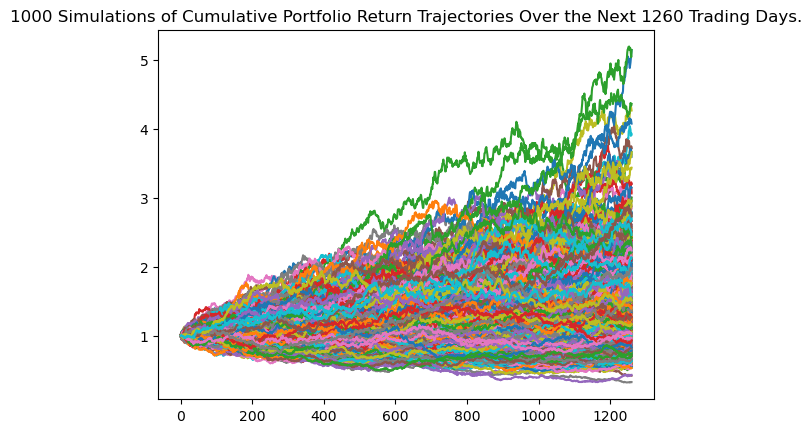

In [24]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals




In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(tbl)

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

### Simulate five year portfolio growth with 60% AT&T stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
# YOUR CODE HERE!

# Print the simulation input data
MC_att.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Simulate five year portfolio growth with 60% Nike stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

# Printing the simulation input data
MC_nike.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Simulate five year portfolio growth with 60% Exxon stock

In [ ]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!

# Printing the simulation input data
MC_exxon.portfolio_data

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Summarize findings across all 4 simulations

YOUR ANSWER HERE!